# CNN Springfield

De los 49 posibles personajes escogí 13, porque son mis favoritos y porque si elegía más mi compu tardaba mucho y colab me cerraba la sesión.

Escogí a los siguientes 13 personajes: 

* Abuelo Simpson
* Apu
* Barney
* Jefe Gorgori
* Duff man
* Willie
* Homero
* Maggie
* Milhouse
* Flanders
* Nelson
* Otto
* Rafa

In [2]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
from random import sample
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

TRAINING_PATH = 'simpsons_dataset/'
TEST_PATH = 'simpsons_testdataset/'

paths = ['abraham_grampa_simpson/',
          'apu_nahasapeemapetilon/',
          'barney_gumble/',
          'chief_wiggum/',
          'duff_man/',
          'groundskeeper_willie/',
          'homer_simpson/',
          'maggie_simpson/',
          'milhouse_van_houten/',
          'ned_flanders/',
          'nelson_muntz/',
          'otto_mann/',
          'ralph_wiggum/']

# Leyendo y visualizando las imágenes

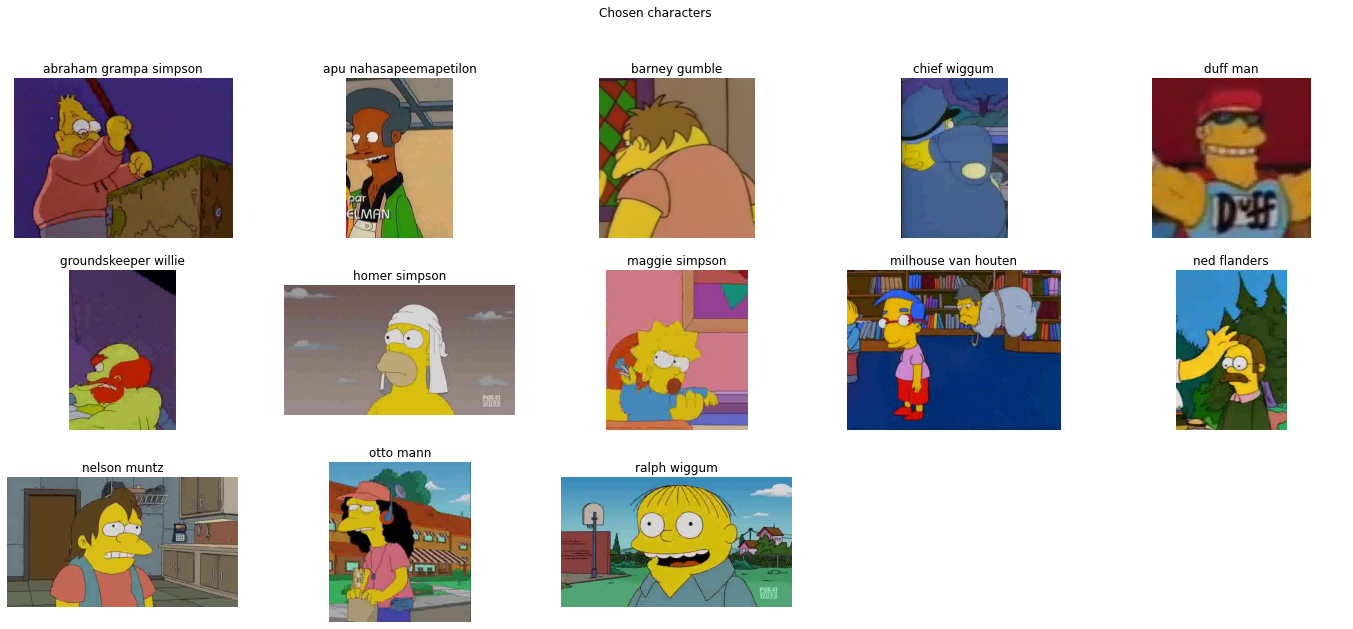

In [2]:
ROWS = 3
COLS = 5
path = 0
amount_images = np.zeros(len(paths))

fig, ax = plt.subplots(3, 5, figsize = (24, 10))
for i in range(ROWS):
    for j in range(COLS):
        pics = os.listdir(TRAINING_PATH + paths[path])
        amount_images[path] = len(pics)
        index = np.random.randint(len(pics))
        ax[i][j].imshow(Image.open(TRAINING_PATH + paths[path] + pics[index]))
        ax[i][j].axis('off')
        ax[i][j].set_title(' '.join(paths[path].split('_')).replace('/', ''))
        path += 1

        if (path > 12):
            break

fig.suptitle('Chosen characters')
ax[2][3].axis('off')
ax[2][4].axis('off')
plt.show()

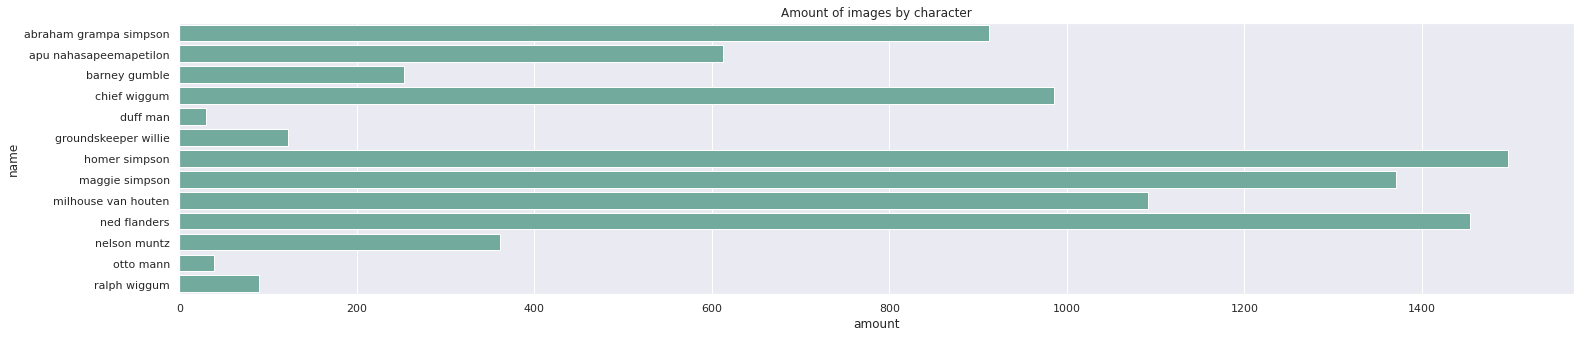

In [3]:
data = {
    'name' : [' '.join(path.split('_')).replace('/', '') for path in paths],
    'amount' : amount_images
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(25, 5))

sns.barplot(
    x = 'amount', 
    y = 'name',
    data = df, 
    estimator = sum, 
    ci = None, 
    color = '#69b3a2').set_title('Amount of images by character');

Aquí podemos observar que se trata, claramente, de un problema desbalanceado, homero tiene más de 4000 imágenes, mientras que personajes como Otto o Duff Man no llegan ni a 250 imágenes. En estos casos lo ideal es conseguir más imágenes de estos último o, en su defecto, deshacerse de algunas imágenes de las clases que tienen más imágenes, en este caso Homero. Homero tiene una gran cantidad de imágenes, por lo que las reduciremos a 1500 imágenes.

En caso de que se haya corrido otra vez el notebook aquí dejo una imagen de la gráfica antes de eliminar imágenes de Homero.

<img src="homero muchos.png">

Una cosa más que haremos es ver cuántos canales diferentes tienen las imágenes de las carpetas cuyos paths están contenidos en el arreglo *paths*.

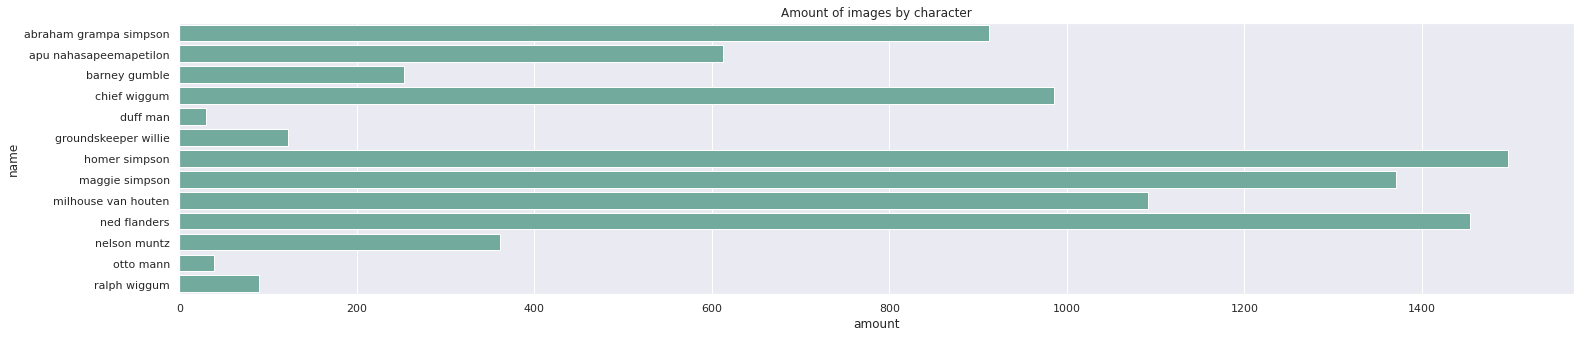

In [4]:
files = os.listdir(TRAINING_PATH + paths[6])
amount_delete = len(files) - 1497
files_to_delete = sample(files, amount_delete)

for fil in files_to_delete:
    os.remove(TRAINING_PATH + paths[6] + fil)

amount_images[6] = len(os.listdir(TRAINING_PATH + paths[6]))

data = {
    'name' : [' '.join(path.split('_')).replace('/', '') for path in paths],
    'amount' : amount_images
}

df = pd.DataFrame(data)

sns.set(style="darkgrid")
plt.figure(figsize=(25, 5))

sns.barplot(
    x = 'amount', 
    y = 'name', 
    data = df, 
    estimator = sum, 
    ci = None, 
    color = '#69b3a2').set_title('Amount of images by character');

Ahora veremos las diferentes dimensiones que tienen las imágenes y los diferentes formatos

Para el conjunto de entrenamiento

In [5]:
dimensions = []
extensions = []

for path in paths:
    pics = os.listdir(TRAINING_PATH + path)

    for pic in pics:
        image_dim = np.asarray(Image.open(TRAINING_PATH + path + pic)).shape
        
        if (len(image_dim) > 2):
            image_dim = image_dim[-1]
        
        else:
            image_dim = 2
        
        extension = pic.split('.')[-1]

    if (image_dim not in dimensions):
        dimensions.append(image_dim)
    
    if (extension not in extensions):
        extensions.append(extension)
  
    print('Done analyzing ' + path)

print('---------------------------------------------')
print('Different dimensions: ', dimensions)
print('Different formats: ', extensions)

Done analyzing abraham_grampa_simpson/
Done analyzing apu_nahasapeemapetilon/
Done analyzing barney_gumble/
Done analyzing chief_wiggum/
Done analyzing duff_man/
Done analyzing groundskeeper_willie/
Done analyzing homer_simpson/
Done analyzing maggie_simpson/
Done analyzing milhouse_van_houten/
Done analyzing ned_flanders/
Done analyzing nelson_muntz/
Done analyzing otto_mann/
Done analyzing ralph_wiggum/
---------------------------------------------
Different dimensions:  [3]
Different formats:  ['jpg']


Para el conjunto de prueba

In [6]:
dimensions = []
extensions = []

for path in paths:
    pics = os.listdir(TEST_PATH + path)

    for pic in pics:
        image_dim = np.asarray(Image.open(TEST_PATH + path + pic)).shape
        
        if (len(image_dim) > 2):
            image_dim = image_dim[-1]
        
        else:
            image_dim = 2
        
        extension = pic.split('.')[-1]

    if (image_dim not in dimensions):
        dimensions.append(image_dim)
    
    if (extension not in extensions):
        extensions.append(extension)
  
    print('Done analyzing ' + path)

print('---------------------------------------------')
print('Different dimensions: ', dimensions)
print('Different formats: ', extensions)

Done analyzing abraham_grampa_simpson/
Done analyzing apu_nahasapeemapetilon/
Done analyzing barney_gumble/
Done analyzing chief_wiggum/
Done analyzing duff_man/
Done analyzing groundskeeper_willie/
Done analyzing homer_simpson/
Done analyzing maggie_simpson/
Done analyzing milhouse_van_houten/
Done analyzing ned_flanders/
Done analyzing nelson_muntz/
Done analyzing otto_mann/
Done analyzing ralph_wiggum/
---------------------------------------------
Different dimensions:  [3]
Different formats:  ['jpg']


# Leyendo el conjunto de datos y aplicando pre procesamiento

In [7]:
# Taken from
# https://stackoverflow.com/questions/12201577/how-can-i-convert-an-rgb-image-into-grayscale-in-python

def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [8]:
def load_image(filename, path,training = True):
    if (training):        
        inimg = tf.cast(tf.image.decode_image(tf.io.read_file(TRAINING_PATH + path + filename)), tf.float32)[..., :3]/255            
  
    else:
        inimg = tf.cast(tf.image.decode_image(tf.io.read_file(TEST_PATH + path + filename)), tf.float32)[..., :3]/255

    inimg = tf.image.resize(inimg, (100, 100))    
    inimg = rgb2gray(inimg)
    inimg = inimg[..., np.newaxis]

    return inimg

In [9]:
X_train = []
y_train = []

X_test = []
y_test = []

paths = ['abraham_grampa_simpson/',
          'apu_nahasapeemapetilon/',
          'barney_gumble/',
          'chief_wiggum/',
          'duff_man/',
          'groundskeeper_willie/',
          'homer_simpson/',
          'maggie_simpson/',
          'milhouse_van_houten/',
          'ned_flanders/',
          'nelson_muntz/',
          'otto_mann/',
          'ralph_wiggum/']

# Training
for i in range(len(paths)):

    files = os.listdir(TRAINING_PATH + paths[i])

    for j in range(len(files)):
        X_train.append(load_image(files[j], paths[i]))
        
    y_train.extend(np.full(len(files), i))

X_train, y_train = shuffle(X_train, y_train)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.batch(32)

# Testing
for i in range(len(paths)):

    files = os.listdir(TEST_PATH + paths[i])

    for j in range(len(files)):
        X_test.append(load_image(files[j], paths[i], training = False))
  
    y_test.extend(np.full(len(files), i))

X_test, y_test = shuffle(X_test, y_test)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_dataset = test_dataset.batch(1)

In [10]:
data = {'shapes': [np.asarray(inp).shape for inp in X_test]}

df = pd.DataFrame(data)
df.value_counts()

shapes       
(100, 100, 1)    942
dtype: int64

In [14]:
model = Sequential([                    
                    Conv2D(64, (3, 3), activation='relu', input_shape = (100, 100, 1)),
                    Conv2D(64, (3, 3), activation='relu'),
                    MaxPooling2D(3),
                    Conv2D(32, (3, 3), activation='relu'),
                    Flatten(),
                    Dense(32, activation='relu'),
                    Dense(13, activation='softmax')
])

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = 'accuracy')

In [15]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 64)        640       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 32)        18464     
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                921632    
_________________________________________________________________
dense_3 (Dense)              (None, 13)               

In [16]:
model.fit(train_dataset, epochs = 10)

Epoch 1/10
276/276 [==============================] - 362s 1s/step - loss: 2.1789 - accuracy: 0.2158
Epoch 2/10
276/276 [==============================] - 366s 1s/step - loss: 1.5560 - accuracy: 0.4890
Epoch 3/10
276/276 [==============================] - 475s 2s/step - loss: 1.2384 - accuracy: 0.5964
Epoch 4/10
276/276 [==============================] - 540s 2s/step - loss: 0.9888 - accuracy: 0.6792
Epoch 5/10
276/276 [==============================] - 462s 2s/step - loss: 0.7631 - accuracy: 0.7489
Epoch 6/10
276/276 [==============================] - 464s 2s/step - loss: 0.5881 - accuracy: 0.8056
Epoch 7/10
276/276 [==============================] - 458s 2s/step - loss: 0.4733 - accuracy: 0.8353
Epoch 8/10
276/276 [==============================] - 408s 1s/step - loss: 0.3662 - accuracy: 0.8703
Epoch 9/10
276/276 [==============================] - 460s 2s/step - loss: 0.2892 - accuracy: 0.8972
Epoch 10/10
276/276 [==============================] - 477s 2s/step - loss: 0.2569 - accura

In [17]:
model.evaluate(test_dataset)

942/942 [==============================] - 15s 16ms/step - loss: 1.8526 - accuracy: 0.7590


[1.8525736331939697, 0.7590233683586121]